In [132]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, GroupShuffleSplit

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNetCV

%matplotlib inline
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = (4, 3) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [67]:
all_data = pickle.load(open('all_data.pkl', 'rb'))

In [68]:
all_data.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,...,thread_end_form_id,thread_number,total_comp_number,total_weight,min_weight,max_weight,mean_weight,year,month,cross_section
id,,,,,,,,,,,,,,,,,,,,,
0,2,S-0066,0,0,Yes,1.00,21.905933,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-1,2,S-0066,0,0,Yes,0.50,12.341214,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-2,2,S-0066,0,0,Yes,0.20,6.601826,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-3,2,S-0066,0,0,Yes,0.10,4.687770,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-4,2,S-0066,0,0,Yes,0.04,3.541561,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129


In [69]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60448 entries, 0 to 30235
Columns: 176 entries, tube_assembly_id to cross_section
dtypes: bool(4), float64(158), int64(9), object(5)
memory usage: 80.0+ MB


In [70]:
# label encoding categorical data
# df_numeric = all_data.select_dtypes(exclude=['object'])
# df_obj = all_data.select_dtypes(include=['object']).copy()

# for c in df_obj:
#     df_obj[c] = LabelEncoder().fit_transform(df_obj[c].astype(str))

# all_data = pd.concat([df_numeric, df_obj], axis=1)

In [71]:
# One hot encoding categorical data
all_data = pd.get_dummies(all_data)

# drop all zero columns
all_data = all_data.loc[:, (all_data != 0).any(axis=0)]
all_data = all_data.astype('float')

In [72]:
all_data.iloc[0, :]

tube_assembly_id                2.000000
annual_usage                    0.000000
min_order_quantity              0.000000
quantity                        1.000000
cost                           21.905933
diameter                        6.350000
wall                            0.710000
length                        137.000000
num_bends                       8.000000
bend_radius                    19.050000
end_a_1x                        0.000000
end_a_2x                        0.000000
end_x_1x                        0.000000
end_x_2x                        0.000000
num_boss                        0.000000
num_bracket                     0.000000
other                           0.000000
spec_num                        0.000000
end_a_forming                   1.000000
end_x_forming                   1.000000
adaptor_adaptor_angle           0.000000
adaptor_connection_type_id      4.000000
adaptor_hex_size               22.220000
adaptor_orientation             0.000000
adaptor_overall_

In [73]:
train_df = all_data.loc[all_data.index <= 0, :]
ylog_train = np.log1p(train_df['cost']).as_matrix()
train_df = train_df.drop('cost', axis=1)
test_df = all_data.loc[all_data.index > 0, :]
test_df = test_df.drop('cost', axis=1)

X_train = train_df.as_matrix()
X_test = test_df.as_matrix()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# split training data into training and validation
X_train_all = X_train.copy()
ylog_train_all = ylog_train.copy()

In [74]:
X_train.shape, X_test.shape, ylog_train.shape

((30213, 305), (30235, 305), (30213,))

In [75]:
# without split 
# df_columns = train_df.columns
# dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns, missing=-999.0)
# dtest = xgb.DMatrix(X_test, feature_names=df_columns)

tube_id_index = train_df.columns.get_loc('tube_assembly_id')
splitter = GroupShuffleSplit(n_splits = 1, test_size = 0.2)
split = splitter.split(X_train_all, ylog_train_all, X_train_all[:, tube_id_index])

for train_index, val_index in split:
    X_train = X_train_all[train_index, :]
    X_val = X_train_all[val_index, :]
    ylog_train = ylog_train_all[train_index]
    ylog_val = ylog_train_all[val_index]

In [76]:
train_index.shape

(24130,)

In [77]:
val_index.shape

(6083,)

In [78]:
X_train.shape, X_val.shape, ylog_train.shape, ylog_val.shape

((24130, 305), (6083, 305), (24130,), (6083,))

In [101]:
K = 5

l1_ratio = 0.1 * np.arange(1, 11)
val_RMSE = np.zeros(len(l1_ratio))
train_std = np.zeros(len(l1_ratio))
train_RMSE = np.zeros(len(l1_ratio))

for i in range(len(l1_ratio)):
    
    print('cv for alpha = {0}'.format(l1_ratio[i]))
    gkf = GroupKFold(n_splits=K)
    cv = gkf.split(X_train, ylog_train, X_train[:, tube_id_index])
    regr = ElasticNetCV(cv=cv, l1_ratio = l1_ratio[i], max_iter = 20000)
    regr.fit(X_train, ylog_train)
    ylog_val_pred = regr.predict(X_val)
    train_RMSE[i] = np.sqrt(np.mean(regr.mse_path_[regr.alphas_ == regr.alpha_]))
    train_std[i] = np.sqrt(np.var(regr.mse_path_[regr.alphas_ == regr.alpha_])/K)
    
    val_RMSE[i] = np.sqrt(mean_squared_error(ylog_val_pred, ylog_val))
    
    print("For alpha = {0}: train RMSLE = {1}".format(l1_ratio[i], train_RMSE[i]))   
    print("For alpha = {0}: test RMSLE = {1}".format(l1_ratio[i], val_RMSE[i]))

cv for alpha = 0.1
For alpha = 0.1: train RMSLE = 0.5091712047693469
For alpha = 0.1: test RMSLE = 0.5202398319984718
cv for alpha = 0.2
For alpha = 0.2: train RMSLE = 0.5087364217116005
For alpha = 0.2: test RMSLE = 0.520217772291112
cv for alpha = 0.30000000000000004
For alpha = 0.30000000000000004: train RMSLE = 0.5086081247555347
For alpha = 0.30000000000000004: test RMSLE = 0.5198549167409915
cv for alpha = 0.4
For alpha = 0.4: train RMSLE = 0.5085567064293657
For alpha = 0.4: test RMSLE = 0.5196800557333194
cv for alpha = 0.5
For alpha = 0.5: train RMSLE = 0.5085263833818421
For alpha = 0.5: test RMSLE = 0.519575528655844
cv for alpha = 0.6000000000000001
For alpha = 0.6000000000000001: train RMSLE = 0.5085092955302707
For alpha = 0.6000000000000001: test RMSLE = 0.519506689154044
cv for alpha = 0.7000000000000001
For alpha = 0.7000000000000001: train RMSLE = 0.5084990644572843
For alpha = 0.7000000000000001: test RMSLE = 0.5194578629965905
cv for alpha = 0.8
For alpha = 0.8: tra

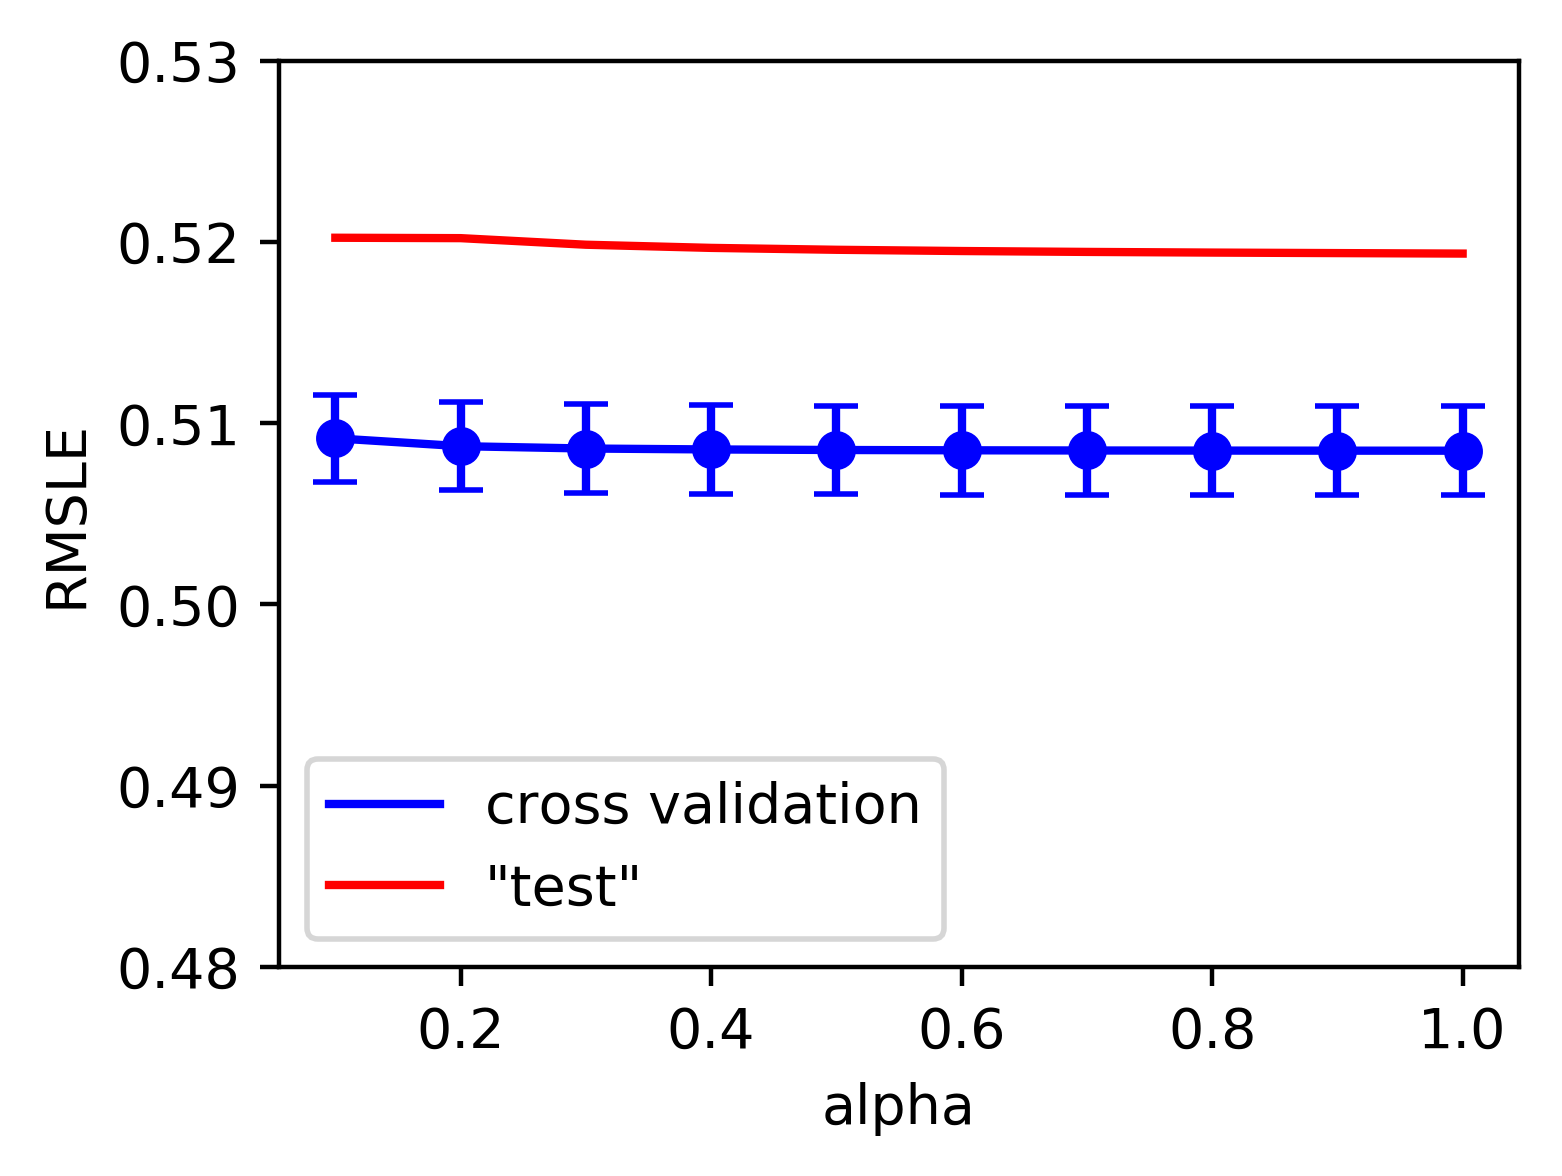

In [133]:
plt.errorbar(l1_ratio, train_RMSE, yerr = train_std, fmt = 'o', color = 'b', capsize = 4)
plt.plot(l1_ratio, train_RMSE, label = 'cross validation', color = 'b')
plt.plot(l1_ratio, val_RMSE, label = '"test"', color = 'r')
plt.xlabel("alpha")
plt.ylabel('RMSLE')
plt.ylim([0.48, 0.53])
plt.legend()
plt.show()

In [103]:
train_std

array([ 0.00239086,  0.00243069,  0.00243382,  0.00243601,  0.0024381 ,
        0.0024409 ,  0.00244347,  0.00244644,  0.00244885,  0.00245175])

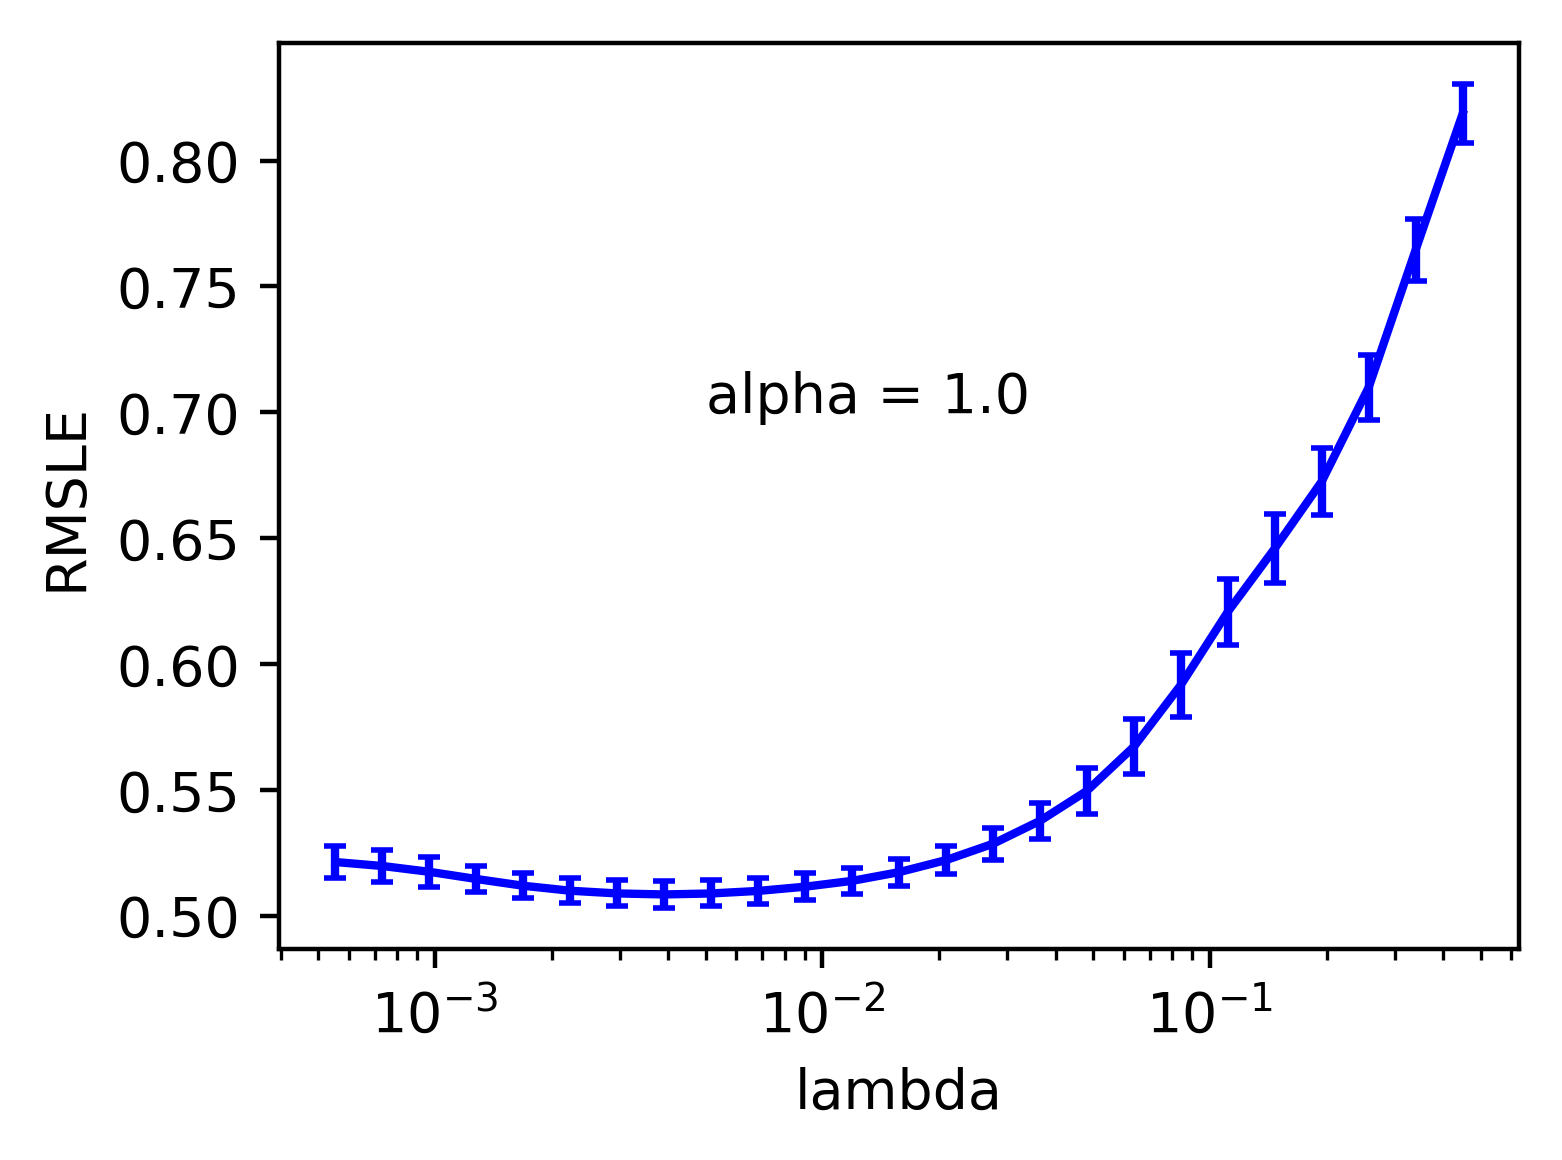

In [159]:
cv_rmse = np.sqrt(np.mean(regr.mse_path_, axis = 1))
cv_std = np.std(np.sqrt(regr.mse_path_), axis = 1)
plt.errorbar(regr.alphas_[::4], cv_rmse[::4], 
             yerr = cv_std[::4], color = 'b', capsize = 2)

ax = plt.gca()
ax.text(0.005, 0.7, 'alpha = 1.0')
ax.set_xscale("log", nonposx='clip')
plt.xlabel("lambda")
plt.ylabel('RMSLE')
plt.legend()
plt.show()